In [1]:
!ls /media/inferics/DataSets/Public_Datasets/JTA-Dataset/

coco_style_convert.py  LICENSE.md	      pose.py		to_poses.py
download_data.sh       new_annotation	      __pycache__	venv
images		       new_image_annotations  README.md		videos
joint.py	       old_annotations	      requirements.txt	visualize.py
jta_banner.jpg	       old_image_annotations  to_imgs.py


In [2]:
import sys
import os

import tensorflow as tf
import numpy as np
import pathlib
import matplotlib.pyplot as plt



In [3]:
image_path = pathlib.Path("/media/inferics/DataSets/Public_Datasets/JTA-Dataset/images")
ANNO_PATH = tf.constant("/media/inferics/DataSets/Public_Datasets/JTA-Dataset/new_image_annotations")

image_ds = tf.data.Dataset.list_files(str(image_path/'train/*/*')).shuffle(10000)

for f in image_ds.take(5):
    print(f.numpy())


b'/media/inferics/DataSets/Public_Datasets/JTA-Dataset/images/train/seq_53/646.jpg'
b'/media/inferics/DataSets/Public_Datasets/JTA-Dataset/images/train/seq_99/12.jpg'
b'/media/inferics/DataSets/Public_Datasets/JTA-Dataset/images/train/seq_134/532.jpg'
b'/media/inferics/DataSets/Public_Datasets/JTA-Dataset/images/train/seq_67/496.jpg'
b'/media/inferics/DataSets/Public_Datasets/JTA-Dataset/images/train/seq_136/713.jpg'


In [4]:
def to_cam_space(joint):
    cam_transform = tf.constant([[1158,0,960],[0,1158,540],[0,0,1]], dtype=tf.float32)
    joint_homog = tf.linalg.matvec(cam_transform, joint)
    cam_space_joint = joint_homog / joint_homog[2]
    return cam_space_joint

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(len(image_batch)):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        poses = label_batch[n]
        for pose in poses:
            for joint in pose:
                text = f"[{joint[0]},{joint[1]}]"
                print(text)
                cam_space_joint = to_cam_space(joint)
                plt.text(cam_space_joint[0],cam_space_joint[1], text)
        plt.axis('off')

def get_annotation_path(img_path):
    # convert the path to a list of path components
    parts = tf.strings.split(img_path, os.path.sep)
    data_split = parts[-3]
    seq = parts[-2]
    img_name = parts[-1]

    anno_name = tf.strings.split(img_name, '.')[0] + '.npy'
    anno_path = tf.strings.join([ANNO_PATH,data_split,seq,anno_name], separator='/')
    # The second to last is the class-directory
    return anno_path

def get_annotation(anno_path):
    poses = np.load(anno_path, allow_pickle=True)
    annos = np.empty([len(poses),15,3], dtype=np.float32)
    for i, pose in enumerate(poses):
        annos[i,0,0] = pose[1].x3d
        annos[i,0,1] = pose[1].y3d
        annos[i,0,2] = pose[1].z3d

        annos[i,1,0] = pose[2].x3d
        annos[i,1,1] = pose[2].y3d
        annos[i,1,2] = pose[2].z3d

        annos[i,2,0] = pose[15].x3d
        annos[i,2,1] = pose[15].y3d
        annos[i,2,2] = pose[15].z3d

        annos[i,3,0] = pose[4].x3d
        annos[i,3,1] = pose[4].y3d
        annos[i,3,2] = pose[4].z3d

        annos[i,4,0] = pose[8].x3d
        annos[i,4,1] = pose[8].y3d
        annos[i,4,2] = pose[8].z3d

        annos[i,5,0] = pose[5].x3d
        annos[i,5,1] = pose[5].y3d
        annos[i,5,2] = pose[5].z3d

        annos[i,6,0] = pose[9].x3d
        annos[i,6,1] = pose[9].y3d
        annos[i,6,2] = pose[9].z3d

        annos[i,7,0] = pose[6].x3d
        annos[i,7,1] = pose[6].y3d
        annos[i,7,2] = pose[6].z3d

        annos[i,8,0] = pose[10].x3d
        annos[i,8,1] = pose[10].y3d
        annos[i,8,2] = pose[10].z3d

        annos[i,9,0] = pose[16].x3d
        annos[i,9,1] = pose[16].y3d
        annos[i,9,2] = pose[16].z3d

        annos[i,10,0] = pose[19].x3d
        annos[i,10,1] = pose[19].y3d
        annos[i,10,2] = pose[19].z3d

        annos[i,11,0] = pose[17].x3d
        annos[i,11,1] = pose[17].y3d
        annos[i,11,2] = pose[17].z3d

        annos[i,12,0] = pose[20].x3d
        annos[i,12,1] = pose[20].y3d
        annos[i,12,2] = pose[20].z3d

        annos[i,13,0] = pose[18].x3d
        annos[i,13,1] = pose[18].y3d
        annos[i,13,2] = pose[18].z3d

        annos[i,14,0] = pose[21].x3d
        annos[i,14,1] = pose[21].y3d
        annos[i,14,2] = pose[21].z3d

    return annos

def process_path(file_path):
    anno_path = get_annotation_path(file_path)
    anno = tf.numpy_function(get_annotation, [anno_path], tf.float32)
    anno.set_shape([None,15,3])

    return file_path, anno


In [5]:
import ShAReD_Net.data.load.dataset_jta.joint as joint
import ShAReD_Net.data.load.dataset_jta.pose as pose
sys.modules['joint'] = joint
sys.modules['pose'] = pose

In [6]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = image_ds.map(process_path,
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)


In [7]:
def person_pos_from_pose(path, poses):
    poss = tf.reduce_mean(poses, axis=-2)
    return path, poss, poses

In [8]:
pos_pose_ds = labeled_ds.map(person_pos_from_pose)

In [9]:
#@tf.function
def poss_and_poses_to_img(path, poss, poses):
    poss_img = poss_to_img(poss)
    poses_img = poses_to_img(poses)

    return path, poss_img, poses_img

def poss_to_img(poss):
    cam_transform = tf.constant([[1158,0,960],[0,1158,540],[0,0,1]], dtype=tf.float32)
    poss_homog = tf.linalg.matvec(cam_transform, poss)
    poss_img = poss_homog / poss_homog[:,None,-1]
    return tf.concat([poss_img[:,:-1],poss[:,None,-1]], axis=-1)

def poses_to_img(poses):
    cam_transform = tf.constant([[1158,0,960],[0,1158,540],[0,0,1]], dtype=tf.float32)
    poses_homog = tf.linalg.matvec(cam_transform, poses)
    poses_img = poses_homog / poses_homog[:,:,None,-1]
    return tf.concat([poses_img[:,:,:-1],poses[:,:,None,-1]], axis=-1)


In [10]:
cam_ds = pos_pose_ds.map(poss_and_poses_to_img)

In [11]:

def poss_and_poses_to_cut(cut_dist, dist_delta, upscaling, cam_intr_f):
    def to_cut(img, poss, poses):
        poss_cut = poss_to_cut(poss, cut_dist, upscaling, cam_intr_f)
        poses_cut = poses_to_cut(poses, cut_dist, upscaling, cam_intr_f)
        poss_cut_filtered, poses_cut_filtered = filter_poss_and_pose(poss_cut, poses_cut, cut_dist, dist_delta)
        return img, poss_cut_filtered, poses_cut_filtered
    return to_cut

def poss_to_cut(poss, dist, upscaling, cam_intr_f):
    poss_cut = poss * upscaling * dist / cam_intr_f
    return tf.concat([poss_cut[:,:-1],poss[:,None,-1]], axis=-1)

def poses_to_cut(poses, dist, upscaling, cam_intr_f):
    poses_cut = poses * upscaling * dist / cam_intr_f
    return tf.concat([poses_cut[:,:,:-1],poses[:,:,None,-1]], axis=-1)

def filter_poss_and_pose(poss, poses, dist, dist_delta):
    indexes = tf.where(tf.abs(poss[:,-1]-dist) < dist_delta)
    filtered_poss = tf.gather_nd(poss, indexes)
    filtered_poses = tf.gather_nd(poses, indexes)

    return filtered_poss, filtered_poses



In [12]:
cut_ds = cam_ds.map(poss_and_poses_to_cut(cut_dist=8, dist_delta=2, upscaling=50, cam_intr_f = 1158))


In [13]:
#TODO TEST VALIDATION to singel item datasets
def to_rel_poses(path, poss, poses):
    return poses-poss[:,None,:]

poses_ds = cut_ds.map(to_rel_poses)
poses_ds = poses_ds.flat_map(lambda x: tf.data.Dataset.from_tensor_slices(x))

In [14]:
import tensorflow_datasets as tfds
import pandas as pd


In [15]:
def to_keypoints(pose):
    return tf.concat(tf.unstack(pose),axis=-1)

In [16]:
keypoint_ds = poses_ds.map(to_keypoints)


In [17]:
numpy_data = tfds.as_numpy(keypoint_ds)
keypoint_df = pd.DataFrame(data=numpy_data)

117.81989288330078


(array([15.,  0.,  1.,  2.,  0.,  6.,  1.,  5.,  0.,  2.,  4.,  2.,  1.,
         1.,  3.,  0.,  0.,  0.,  0.,  2.]),
 array([  0.48733282,   6.35396082,  12.22058883,  18.08721683,
         23.95384483,  29.82047284,  35.68710084,  41.55372884,
         47.42035685,  53.28698485,  59.15361285,  65.02024086,
         70.88686886,  76.75349686,  82.62012486,  88.48675287,
         94.35338087, 100.22000887, 106.08663688, 111.95326488,
        117.81989288]),
 <a list of 20 Patch objects>)

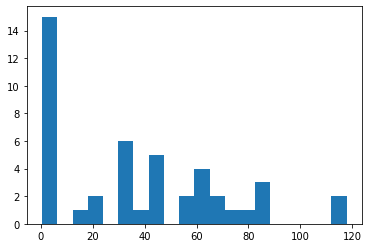

In [18]:
inter_person_size_df = (keypoint_df.max() - keypoint_df.min())
print(inter_person_size_df.max())
plt.hist(inter_person_size_df, 20)

In [19]:
person_size_df = keypoint_df.T.max() - keypoint_df.T.min()

120.32809448242188
31.591445922851562


(array([5.2000e+01, 5.2300e+02, 1.4940e+03, 4.3380e+03, 9.7700e+03,
        1.5065e+04, 5.4611e+04, 7.0004e+04, 6.0300e+04, 5.1396e+04,
        4.3102e+04, 3.3964e+04, 2.9241e+04, 2.4010e+04, 1.7895e+04,
        9.3400e+03, 1.2130e+03, 2.7400e+02, 4.8000e+01, 9.0000e+00]),
 array([ 31.59144592,  36.02827835,  40.46511078,  44.90194321,
         49.33877563,  53.77560806,  58.21244049,  62.64927292,
         67.08610535,  71.52293777,  75.9597702 ,  80.39660263,
         84.83343506,  89.27026749,  93.70709991,  98.14393234,
        102.58076477, 107.0175972 , 111.45442963, 115.89126205,
        120.32809448]),
 <a list of 20 Patch objects>)

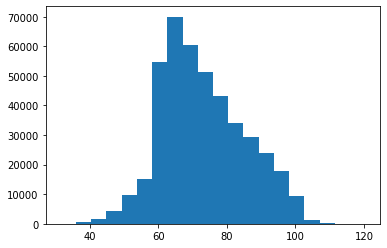

In [20]:
print(person_size_df.max())
print(person_size_df.min())

plt.hist(person_size_df, 20)
